# Introduction

Microsoft wishes to break into the movie-making business and seeks advice about what kinds of movies to make.

First, we must decide what constitutes a success, and second, what factors we can attribute that success to.

A successful movie makes money, but this can be measured in different ways, namely as profit or as ROI (return on investment). A higher average ROI indicates that a project is less risky. But making your money back tenfold doesn't necessarily mean a lot if both your investment and returns are quite low. Microsoft may decide for itself whether it seeks to maximize its profits or its ROI.

We will use available data to understand and attribute what factors can lead to higher profits and ROI. Some obvious factors to explore are simple details like runtime, genre, and MPAA rating.

We can look deeper into the data to explore what effect certain cast and crew members have on the profit and ROI of a project. Specifically, for a given movie, we will compare the past profits and ROI of that movie's director and of that movie's lead actors. That is, for example, we will calculate an average ROI (or profit) for all of Steven Spielberg's projects *before* Jurassic Park (Jaws, E.T., etc.) and compare that average *past* ROI (or profits) to the *actual* ROI (or profit) of Jurassic Park. Separately, we would do the same for the top-billed actors of a movie, such as Jeff Goldblum in Jurassic Park.

All of this investigation should provide Microsoft with answers to broad categorical questions they face in their movie-making process. They can shape their projects according to our advice on runtime, genre, MPAA rating, and director and actor hiring in order to maximize ROI or profit according to their goals.

# Data Understanding

## Importing data

In [1]:
# import all necessary libraries for use in this notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
import sqlite3
import re

There are 8 SQL tables, 3 csv files, and 2 tsv files.

In [2]:
# import SQL tables as dataframes

conn = sqlite3.connect("data/im.db")

movie_basics_df = pd.read_sql("""
SELECT *
FROM movie_basics
;""", conn)

directors_df = pd.read_sql("""
SELECT *
FROM directors
;""", conn)

known_for_df = pd.read_sql("""
SELECT *
FROM known_for
;""", conn)

movie_akas_df = pd.read_sql("""
SELECT *
FROM movie_akas
;""", conn)

movie_ratings_df = pd.read_sql("""
SELECT *
FROM movie_ratings
;""", conn)

persons_df = pd.read_sql("""
SELECT *
FROM persons
;""", conn)

principals_df = pd.read_sql("""
SELECT *
FROM principals
;""", conn)

writers_df = pd.read_sql("""
SELECT *
FROM writers
;""", conn)

conn.close()

In [3]:
# import tsv files as dataframes
rtm_old_df = pd.read_csv('data/rt.movie_info.tsv', delimiter='\t')
rtr_old_df = pd.read_csv('data/rt.reviews.tsv', delimiter='\t', encoding= 'unicode_escape')

# import csv files as dataframes
bom_df = pd.read_csv('data/bom.movie_gross.csv')
tmdb_df = pd.read_csv('data/tmdb.movies.csv')
tn_df = pd.read_csv('data/tn.movie_budgets.csv')

# import new, better files from Rotten Tomatoes
rtm_df = pd.read_csv('data/rotten_tomatoes_movies.csv')
rtr_df = pd.read_csv('data/rotten_tomatoes_critic_reviews.csv')

## Some functions

To better understand a given dataframe, we'll use a function called "assess" to summarize its duplicates, missing data, and data types.

In [4]:
# This function will show (1) the number of records, (2) number of duplicate records,
# (3) column names, (4) the number of missing items from each column,
# and (5) the data types of each column

def assess(df):
    print(str(len(df)) + ' records.')
    print()
    if len(df) == len(df.drop_duplicates()):
        print('This dataframe contains no duplicates.')
    else:
        num = len(df) - len(df.drop_duplicates())
        print('This dataframe contains ' + str(num) + ' duplicates.')
    print()
    print('Columns, and their missing data:')
    print(df.isna().sum())
    print()
    print('Data types:')
    print(df.dtypes)

Another function will serve well to make plots more illuminating by removing outliers from certain fields.

Note: the purpose is only to remove the outliers from the *plot*. The outliers will very much still factor into calculations of correlations, etc. unless otherwise specified.

In [5]:
# this function takes a dataframe and one of its columns and returns the same dataframe minus that column's outliers
# the "mult" parameter decides how many standard deviations to allow within the range to be trimmed
def outlier_trim(df, field, mult):
    mu = df[field].mean()
    sd = df[field].std()
    top = mu + mult * sd
    bottom = mu - mult * sd
    df = df[(df[field] > bottom) & (df[field] < top)]
    return df

The following function will cut the values of a volumn into a number of bins corresponding to equal percentiles of that column's values.

In [6]:
# this functon takes a dataframe and one of its columns and returns a new column that categorically
# identifies which percentile "bin" that record belongs to
# the "num" parameter gives the number of bins
# Note: creating too many bins can cause errors if the bin divisions are not distinct from each other
def make_bins(df, field, num):
    binp = []
    for i in range(num):
        binp.append((i+1)/num)
    bins = []
    for i in range(num+2):
        bins.append(df[field].describe(percentiles=binp)[i+3])
    df['bins'] = pd.cut(df[field], bins)

The following function will help us plot graphs of dataframes that show the distribution of its records by year.

In [7]:
# this function will help generate a line graph showing how many records a dataframe has by year
def yr_plt(df, start, end):
    return df[(df['year'] > start) & (df['year'] <= end)].groupby(['year']).count()['title']

This function will compare current and past values (see explanation below re: Spielberg & Jurassic Park) and provide a red 45° line for the purpose of comparison.

In [8]:
# this function will trim outliers and create a plot comparing current to past data
# it will also feature a 45° line (y = x) to show where a feature is worse or better than expected

def past_plot(df, field, plot_title):
    ax = plt.gca()
    df = outlier_trim(df, field, 1.5)
    df = outlier_trim(df, 'past ' + field, 1.5)
    df.plot('past ' + field, field, kind='scatter', title = plot_title, ax=ax)
    maxval = int(round(min(df[field].max(),df['past ' + field].max()),0))
    minval = int(round(max(df[field].min(),df['past ' + field].min()),0))
    
    df45 = pd.DataFrame({
        'x': np.linspace(minval, maxval, 101),
        'y': np.linspace(minval, maxval, 101)
    
   })
    df45.plot('x', 'y', xlabel='past ' + field, ylabel=None, kind='line', color='red', ax=ax, legend=None)

## Summary of resources

Of the 5 families of resources, we will take a preliminary look at what records they have and what those records offer.

### IMDb • Movie Basics (movie_basics_df)

records: 146,144

period: 2010-2020

value addition: runtime, genres

issues: some 'original title' values missing, but all 'primary title' values are present

*this resource is linked to several other tables, as noted below*

### The Movie Database (tmdb_df)

records: 26,517

period: 1930-2020

value addition: 'popularity'

issues: this notion of popularity isn't well defined and may not be of much use

### Rotten Tomatoes • Movies (rtm_df)

records: 17,712

period: 1914-2020

value addition: MPAA rating (e.g. PG-13), critics rating, audience rating, runtime, genres, director(s)

issues: many titles have parentheses, e.g. "Batman (1989)"

*NOTE: the rotten tomatoes files that were provided contained no titles; instead, the files we used were obtained online and contain roughly 10 times as many records as the provided ones (and include titles)*

### The Numbers (tn_df)

records: 5,782

period: 1915-2020

value addition: grosses and budgets

issues: none

### Box Office Mojo (bom_df)

records: 3,387

period: 2010-2018

value addition: grosses

issues: many grosses are incomplete

## Additional resources

### IMDb-linked tables

persons (persons_df): 606,647 records linking individuals to acting/writing/directing roles in movies

directors (directors_df): associates 140,417 movies with 109,253 directors

writer (writers_df): associates 110,261 movies with 122,576 writers

principals (principals_df): associates 143,454 movies with various movie personnel and ranks their importance on a given movie

known for (known_for_df): associates 576,444 persons with 514,781 movies that they are primarily known for

AKAs (movie_akas_df): associates 122,302 movies with alternate titles

ratings (movie_ratings_df): ratings for 73,856 movies

### Rotten Tomatoes reviews (rtr_df)

records: 1,130,017 movie reviews

# Data Preparation

In order to work with the data in more productive ways, we will need to perform a number of tasks first: remove duplicates, standardize column information that is common across multiple resources, and make other various edits.

Once the "year" values are standardized, we can compare the resources by the distribution of their records over time.

## Removing duplicates

In [9]:
directors_df.drop_duplicates(inplace=True)
writers_df.drop_duplicates(inplace=True)
rtr_df.drop_duplicates(inplace=True)

## Editing data

### renaming columns

This will help standardize some naming conventions across different dataframes.

In [10]:
movie_basics_df.rename(columns={
    'primary_title': 'title', 
    'start_year': 'year', 
    'runtime_minutes': 'runtime'
}, inplace=True)

tn_df.rename(columns={
    'movie': 'title',
    'production_budget': 'budget',
    'worldwide_gross': 'gross'
}, inplace=True)

rtm_df.rename(columns={
    'movie_title': 'title',
    'content_rating': 'MPAA',
    'directors': 'director'
}, inplace=True)

### titles

Some Rotten Tomatoes records contain titles with parenthetical phrases that prevent them from matching other records. Removing these parenthetical phrases will allow us to match a far greater number of records.

In [11]:
# this will remove parenthetical phrases from titles in the rotten tomatoes records
rtm_df['title'] = rtm_df.title.map(lambda x: re.sub(r'\([^)]*\)', '', x).strip())

### budgets and grosses

Some of the records from Box Office Mojo are missing domestic, foreign, or both grosses. Since the only value that bom_df possibly adds is data involving grosses, we can safely drop these incomplete records, since they would not be usable.

In [12]:
bom_df.dropna(subset=['domestic_gross', 'foreign_gross'], inplace=True)

It is necessary to reformat all budget and gross values as integers

In [13]:
# This function will convert dollar amounts from strings to integers and resolve any other formatting issues
def dol_to_int(dol):
    if type(dol) == int:
        return dol
    if type(dol) == str:
        return int(round(float(dol.replace(',', '').replace('$', '')),0))
    if dol > 0:
        return int(round(dol,0))
    else:
        return 0

# perform the conversion for The Numbers
tn_df['budget'] = tn_df.budget.map(lambda x: dol_to_int(x))
tn_df['gross'] = tn_df.gross.map(lambda x: dol_to_int(x))

# perform the conversion for Box Office Mojo
bom_df['domestic_gross'] = bom_df.domestic_gross.map(lambda x: dol_to_int(x))
bom_df['foreign_gross'] = bom_df.foreign_gross.map(lambda x: dol_to_int(x))

Here we will create a "gross" column for bom_df as well. It's not clear whether we'll be able to use any of these bom_df records, since we don' have budget data for those records. In case the total grosses become useful, we'll calculate them here.

In [14]:
bom_df['gross'] = bom_df['domestic_gross'] + bom_df['foreign_gross']

We'll drop any records that have zeros as any of these values, as they must surely be inaccurate.

In [15]:
tn_df.drop(tn_df[tn_df['budget'] == 0].index, inplace=True)
tn_df.drop(tn_df[tn_df['gross'] == 0].index, inplace=True)
bom_df.drop(tn_df[tn_df['gross'] == 0].index, inplace=True)

### dates, years, and comparisons of period of record

We need to standardize all the "years" data in order to better understand and compare the periods of record. This will also come in handy later when we need to evaluate *past* phenomena related to a movie's director and top-billed cast.

In [16]:
# Here we'll add year columns to the tables that lack them (and for which a year would be relevant).
tmdb_df['year'] = tmdb_df.release_date.map(lambda x: x[:4])
tn_df['year'] = tn_df.release_date.map(lambda x: x[-4:])
rtm_df['year'] = rtm_df['original_release_date'].apply(lambda x: str(x)[:4] if type(x) == str else 0)

In [17]:
# Then we'll recast those columns as integers
tmdb_df = tmdb_df.astype({'year': 'int64'})
tn_df = tn_df.astype({'year': 'int64'})
rtm_df = rtm_df.astype({'year': 'int64'})

# Note that missing year entries for rtm_df were set to 0

There are IMDb records for years later than 2020, which are evidently not records of movies that had actually been released. We can safely drop these records.

In [18]:
movie_basics_df.drop(movie_basics_df[movie_basics_df['year'] > 2020].index, inplace=True)

It will be important to understand how the periods of record compare and overlap.

Now that we have data for the years of the records that we can interpret, we'll create plots that compare the number and periods of records side by side.

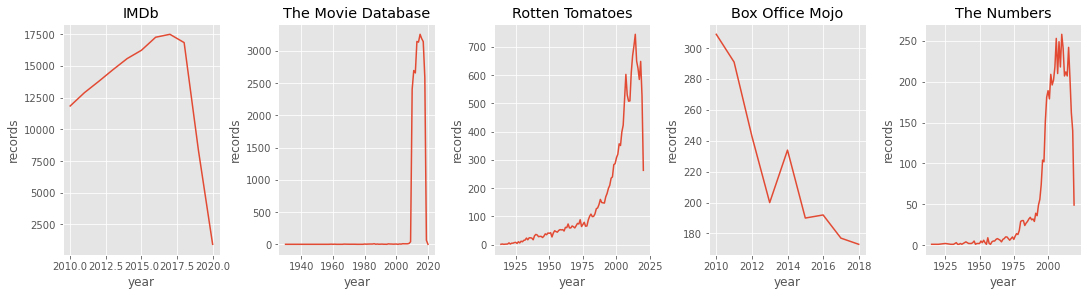

In [19]:
start = 0
end = 2020

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)

fig.set_figwidth(15)

ax1.plot(yr_plt(movie_basics_df, start, end))
ax1.set_xlabel('year')
ax1.set_ylabel('records')
ax1.set_title('IMDb')

ax2.plot(yr_plt(tmdb_df, start, end))
ax2.set_xlabel('year')
ax2.set_ylabel('records')
ax2.set_title('The Movie Database')

ax3.plot(yr_plt(rtm_df, start, end))
ax3.set_xlabel('year')
ax3.set_ylabel('records')
ax3.set_title('Rotten Tomatoes')

ax4.plot(yr_plt(bom_df, start, end))
ax4.set_xlabel('year')
ax4.set_ylabel('records')
ax4.set_title('Box Office Mojo')

ax5.plot(yr_plt(tn_df, start, end))
ax5.set_xlabel('year')
ax5.set_ylabel('records')
ax5.set_title('The Numbers')

fig.tight_layout(pad = 0.3)

plt.show()

We have identified that The Movie Database and Box Office Mojo records are not useful. Of the three resources we plan to use, IMDb is strictly limited to records after 2010, whereas Rotten Tomatoes and The Numbers share a similar distribution going back to the silent era.

## Feature creation

### convert budgets and grosses to 2020 dollars

This will be necessary to make comparisons valid across time. A million dollars today is not the same as a million dollars 50 years ago, or even 5 years ago. Using available data on inflation, we will convert all dollar values to their 2020 equivalents.

It will not ultimately matter whether we use 2020 equivalents or 1929 equivalents. Our exploration involves the *effect* certain factors have on profit (and ROI), and these effects are measured not in *absolute* terms, but as *multiples*. For example, an MPAA rating of G might generate *12% higher* profits than a rating of PG-13, which would be true regardless of which year's equivalent dollar value we used as a basis.

In [20]:
# import a dataframe containing historical data about inflation
inflation_df = pd.read_csv('data/inflation_data.csv')

# this function will help generate a multiplier to correct dollar values for inflation to 2020 equivalent values
def inf(yr):
    return float(20.54 / inflation_df[inflation_df['year'] == yr]['amount'])

# update the relevant entries
tn_df['multiplier'] = tn_df.year.map(lambda x: inf(x))
tn_df['budget'] = tn_df['budget'] * tn_df['multiplier']
tn_df['gross'] = tn_df['gross'] * tn_df['multiplier']

bom_df['multiplier'] = bom_df.year.map(lambda x: inf(x))
bom_df['gross'] = bom_df['gross'] * bom_df['multiplier']

### profit and ROI

Our primary (or perhaps only) data on money quantities from movies comes from The Numbers. We can use that data to create new columns that report the profit and ROI (return on investment) for each movie.

Later we will add more columns that calculate *past* profits and ROI according to certain criteria.

In [21]:
tn_df['profit'] = tn_df['gross'] - tn_df['budget']
tn_df['ROI'] = tn_df['gross'] / tn_df['budget']

In all explorations related to profit and ROI, we will be limited to movies which have these records from The Numbers. There are 5,415 such movies. Occasionally we may see dataframes going forward with more than this number of entries, because, for example, some movies have more than one director.

# Data Analysis

### runtime dataframe

In order to explore the relationship between runtime (the duration of a movie) to its profits and ROI, we'll begin by joining records from The Numbers (which contain profit and ROI data) with records from IMDb (which contain runtime data).

In [22]:
# prepare trimmed version of tn_df
df0 = tn_df.drop(['id', 'release_date', 'budget', 'domestic_gross', 'gross', 'multiplier'], axis=1)

# select only records with nonzero runtime
df1 = movie_basics_df[movie_basics_df['runtime'] > 0]

# create merged dataframe
runtime_df_1 = df0.merge(df1[['title', 'year', 'runtime']])

# show how many records we've captured
runtime_df_1.count()['title']

1408

There are 1,408 records that IMDb has in common with The Numbers. The only other resource with runtime data is Rotten Tomatoes. We'll join those records as well, and then we'll join the two dataframes with each other.

In [23]:
# prepare trimmed version of rtm_df
df2 = rtm_df[rtm_df['runtime'] > 0]

# create merged dataframe
runtime_df_2 = df0.merge(df2[['title', 'year', 'runtime']])

# show how many records we've captured
runtime_df_2.count()['title']

4012

In [24]:
# combine the dataframes
runtime_df = pd.concat([runtime_df_1, runtime_df_2])

# show how many records we've captured
runtime_df.count()['title']

5420

Rotten Tomatoes had 4,012 records that matched records from The Numbers. After combining both IMDb and Rotten Tomatoes runtime records, we had 5,420 records to inspect.

Addressing duplicates is a little tricky in this instance. We can expect to see duplicate titles that do not necessarily refer to the same movie. If they have different years, then they can safely be considered unique from each other. When the title and year match, however, there are two possibilities to consider:

1. The runtimes match: This means they are true duplicates, and we should keep one of the values (the first one).
2. The runtimes *don't* match: This may be because there are different versions of the movie, e.g. the theatrical release, the director's cut, and/or a DVD release. We're concerned with the theatrical release, but if we can't tell which record corresponds to the theatrical release, then we should discard *all* the records of that movie — we don't want to let false values skew our quantitative results about runtime.

In [25]:
# when the title, year, and runtime all match, we'll keep one
runtime_df.drop_duplicates(subset=['title', 'year', 'runtime'], keep='first', inplace=True)
runtime_df.count()['title']

4697

In [26]:
# when the title and year match, but runtimes are different, we'll drop them all
runtime_df.drop_duplicates(subset=['title', 'year'], keep=False, inplace=True)
runtime_df.count()['title']

3691

In the end, we kept 3,691 records. Now that we know which records we'll be exploring, let's look at the distribution of those records by year.

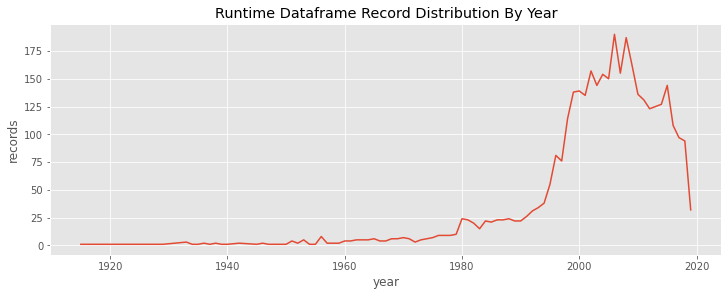

In [27]:
start = 0
end = 2020

fig, ax = plt.subplots(1,1)

fig.set_figwidth(10)

ax.plot(yr_plt(runtime_df, start, end))
ax.set_xlabel('year')
ax.set_ylabel('records')
ax.set_title('Runtime Dataframe Record Distribution By Year')

fig.tight_layout(pad = 0.3)

plt.show()

Next we can look at the general distribution of the runtimes of those records.

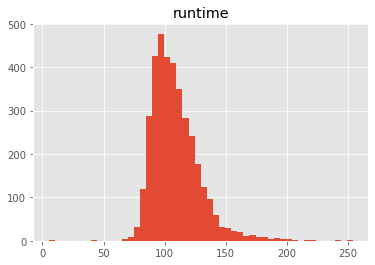

In [28]:
# look at the general distribution of runtimes
runtime_df.hist(column='runtime', bins=50);

Removing the outliers gives a slightly better picture, as shown below.

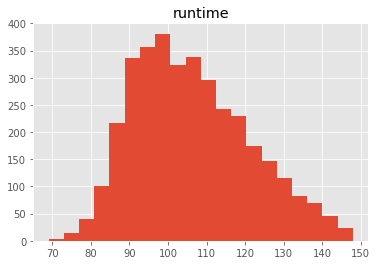

In [29]:
# look at the general distribution of runtimes
outlier_trim(runtime_df, 'runtime', 2).hist(column='runtime', bins=20);

From the two graphs above, we see that most movies we have records for are between about 80 and 130 minutes long, and they primarily come from the late 90s and later.

Next, we'll look at the relationship between runtime and our two success metrics: profit and ROI. For the graphs below, we will remove runtime outliers and profit outliers of 2+ standard deviations.

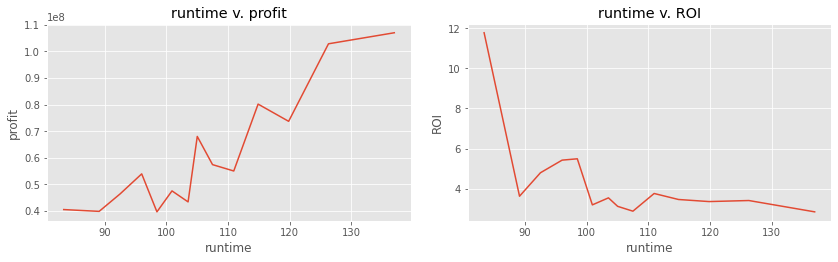

In [30]:
# trim the outliers from this dataframe
df = outlier_trim(runtime_df, 'runtime', 2)
df = outlier_trim(df, 'profit', 2)

# create 15 bins of equal runtime percentiles
make_bins(df, 'runtime', 13)

# generate new simplified data corresponding only to the 15 bins
df = df.groupby('bins').mean()
x = df['runtime']
y1 = df['profit']
y2 = df['ROI']

# plot the data
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_figwidth(12)

ax1.plot(x,y1)
ax1.set_xlabel('runtime')
ax1.set_ylabel('profit')
ax1.set_title('runtime v. profit')

ax2.plot(x,y2)
ax2.set_xlabel('runtime')
ax2.set_ylabel('ROI')
ax2.set_title('runtime v. ROI')

fig.tight_layout(pad = 2.0)

plt.show()

The simple observation here is that profit increases with runtime while ROI decreases with runtime.

The removal of outliers primarily allows us to zoom in on the graph but does not otherwise affect the overall shape.

### genre dataframe

In order to explore the relationship between the genre of a movie and its moneymaking potential, we'll join the records from The Numbers (which contain profit and ROI data) with records from IMDb and Rotten Tomatoes (which contain  data on movie genres).

In [31]:
# prepare trimmed version of tn_df
df0 = tn_df.drop(['id', 'release_date', 'budget', 'domestic_gross', 'gross', 'multiplier'], axis=1)

# prepare trimmed version of movie_basics_df
df1 = movie_basics_df.drop(movie_basics_df[movie_basics_df['genres'].isna()].index)
df1['genres'] = df1.genres.map(lambda x: x.lower())

# create merged dataframe
genre_df_1 = df0.merge(df1[['title', 'year', 'genres']])

# show how many records we've captured
genre_df_1.count()['title']

1418

In [32]:
# prepare trimmed version of rtm_df
df2 = rtm_df.drop(rtm_df[rtm_df['genres'].isna()].index)
df2['genres'] = df2.genres.map(lambda x: x.lower())

# create merged dataframe
genre_df_2 = df0.merge(df2[['title', 'year', 'genres']])

# show how many records we've captured
genre_df_2.count()['title']

4035

In [33]:
# combine the dataframes
genre_df = pd.concat([genre_df_1, genre_df_2])

# show how many records we've captured
genre_df.count()['title']

5453

The Numbers had 1,418 records in common with IMDb and 4,035 records in common with Rotten Tomatoes, totalling 5,453 when combined.

When we addressed certain duplicates in the runtime dataframe, we chose to discard ALL duplicated records where the runtimes differed. When genres differ, however, it may be because one resource considers it primarily an "action" movie while another considers it an "action-comedy". Since genres are subjective, it is more acceptable in this case to (arbitrarily) keep the first such record, rather than discard all records.

In [34]:
# drop duplicates for title and year; keep first record
genre_df.drop_duplicates(subset=['title', 'year'], keep='first', inplace=True)

# show how many records we've captured
genre_df.count()['title']

4197

In the end, we kept 4,197 records. Now we'll look at the distribution over time.

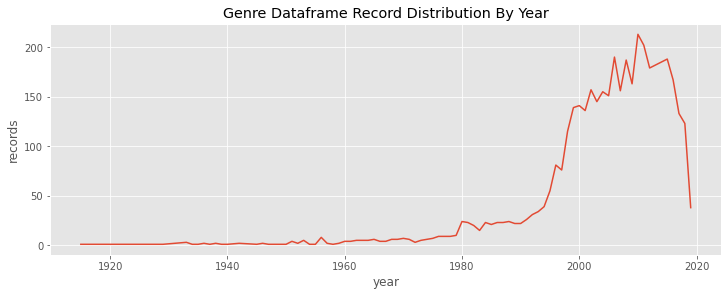

In [35]:
start = 0
end = 2020

fig, ax = plt.subplots(1,1)

fig.set_figwidth(10)

ax.plot(yr_plt(genre_df, start, end))
ax.set_xlabel('year')
ax.set_ylabel('records')
ax.set_title('Genre Dataframe Record Distribution By Year')

fig.tight_layout(pad = 0.3)

plt.show()

### genre tags

It will take some effort to isolate single genres, because nearly all records include multiple genres. First we need to generate a list of the genres and then standardize them, as IMDb and Rotten Tomatoes use different genre naming conventions. For example, one uses "family" while the other uses "kids & family", which are clearly meant to be the same genre.

In [36]:
genres = set()
for genre_list in genre_df['genres']:
    genre_list = genre_list.lower().split(',')
    for genre in genre_list:
        genres.add(genre.strip())
genres

{'action',
 'action & adventure',
 'adventure',
 'animation',
 'art house & international',
 'biography',
 'classics',
 'comedy',
 'crime',
 'cult movies',
 'documentary',
 'drama',
 'faith & spirituality',
 'family',
 'fantasy',
 'gay & lesbian',
 'history',
 'horror',
 'kids & family',
 'music',
 'musical',
 'musical & performing arts',
 'mystery',
 'mystery & suspense',
 'romance',
 'sci-fi',
 'science fiction & fantasy',
 'special interest',
 'sport',
 'sports & fitness',
 'television',
 'thriller',
 'war',
 'western'}

In [37]:
len(genres)

34

It will be of great help to standardize some of these 34 genre names. We will collapse "adventure" and "action" into one genre, and similarly collapse "mystery", "suspense" and "thriller", as well as a few others seen in the code below.

In [38]:
# all combinations of action and adventure will be called "action"
genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('action & adventure', 'action'))
genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('adventure', 'action'))

# all combinations of music(al) and performing arts will be called "music"
genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('musical & performing arts', 'music'))
genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('musical', 'music'))

# all combinations of mystery, suspense and thriller will be called "suspense"
genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('mystery & suspense', 'suspense'))
genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('mystery', 'suspense'))
genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('thriller', 'suspense'))

# all combinations of sci-fi and fantasy will be called "sci-fi and fantasy"
genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('sci-fi & fantasy', 'fantasy'))
genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('science fiction & fantasy', 'fantasy'))
genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('sci-fi', 'fantasy'))
genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('fantasy', 'sci-fi & fantasy'))

# anime and manga will be lumped in with "animation"
genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('anime & manga', 'animation'))

genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('kids & family', 'family'))

genre_df['genres'] = genre_df.genres.map(lambda x: x.replace('sports & fitness', 'sport'))

genres = set()
for genre_list in genre_df['genres']:
    genre_list = genre_list.lower().split(',')
    for genre in genre_list:
        genres.add(genre.strip())

len(genres)

24

Now we'll explore the distribution of genres.

In [39]:
# we'll create dictionaries that calculate data according to individual genres
# this will show three things: (1) how many instances of a genre there are,
# (2) the average profit for that genre, and
# (3) the average ROI for that genre
genre_count = {}
genre_profit = {}
genre_ROI = {}

for genre in genres:
    genre_count[genre] = genre_df.genres.str.contains(genre).sum()
    genre_profit[genre] = int(round((genre_df.genres.str.contains(genre) * genre_df.profit).mean(),0))
    genre_ROI[genre] = round((genre_df.genres.str.contains(genre) * genre_df.ROI).mean(),2)

genre_count = sorted(genre_count.items(), key=lambda x: x[1])
genre_profit = sorted(genre_profit.items(), key=lambda x: x[1])
genre_ROI = sorted(genre_ROI.items(), key=lambda x: x[1])

The bar graphs below will compare the genres by
1. how many instances there are of each
2. the average profit of each
3. the average ROI of each

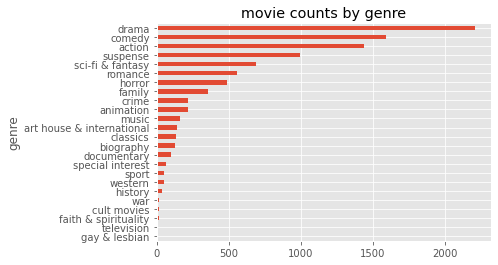

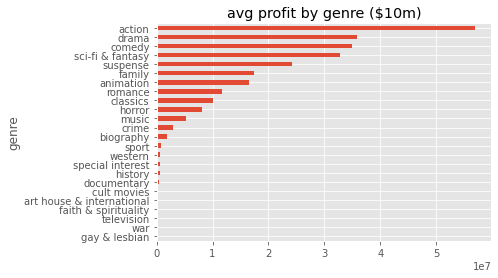

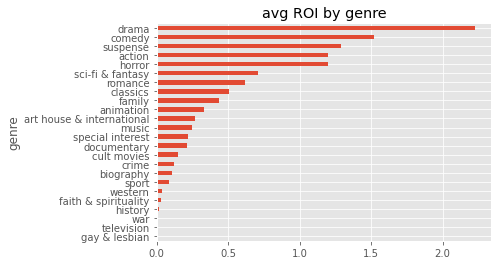

In [40]:
ax1 = pd.DataFrame(genre_count).plot.barh(x=0, y=1, xlabel='genre', title='movie counts by genre', legend=None)
ax2 = pd.DataFrame(genre_profit).plot.barh(x=0, y=1, xlabel='genre', title='avg profit by genre ($10m)', legend=None)
ax3 = pd.DataFrame(genre_ROI).plot.barh(x=0, y=1, xlabel='genre', title='avg ROI by genre', legend=None)

Action movies generate the greatest average profit by far. After that, a cluster of drama / comedy / sci-fi & fantasy / suspense are next.

Drama movies generate the greatest average ROI by far. Then comedy / suspense / action / horror are next. *And none of the other genres have an ROI greater than 1!!*.

There is much to be learned from this data. Sci-fi & fantasy movies seem to be rather risky. Horror movies are safe (ROI) but not very profitable.

### MPAA rating

The only resource with data on MPAA ratings is Rotten Tomatoes. We will process this data much as we did the data on genres, except each record has only one rating, and we will not need to extract individuals from a list.

In [41]:
# prepare trimmed version of tn_df
df0 = tn_df.drop(['id', 'release_date', 'budget', 'domestic_gross', 'gross', 'multiplier'], axis=1)

# prepare trimmed version of rtm_df
df1 = rtm_df.drop(rtm_df[rtm_df['MPAA'].isna()].index)

# create joined dataframe
rating_df = df0.merge(df1[['title', 'year', 'MPAA']])

# show how many records we've captured
rating_df.count()['title']

4035

In [42]:
# drop duplicates for title and year; keep first record
rating_df.drop_duplicates(subset=['title', 'year'], keep='first', inplace=True)

# show how many records we've captured
rating_df.count()['title']

4034

We have 4,034 records. Now we'll look at the distribution over time.

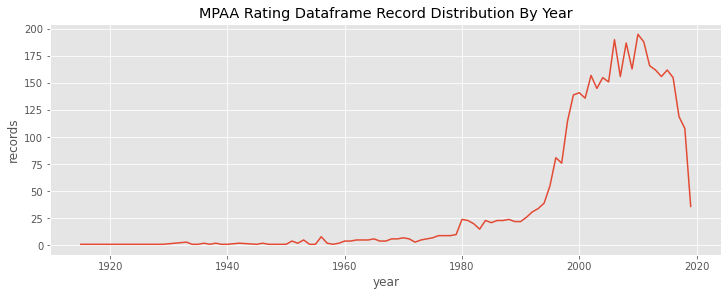

In [43]:
start = 0
end = 2020

fig, ax = plt.subplots(1,1)

fig.set_figwidth(10)

ax.plot(yr_plt(rating_df, start, end))
ax.set_xlabel('year')
ax.set_ylabel('records')
ax.set_title('MPAA Rating Dataframe Record Distribution By Year')

fig.tight_layout(pad = 0.3)

plt.show()

In [44]:
ratings = set()
for rating in rating_df['MPAA']:
    ratings.add(rating)
ratings

{'G', 'NC17', 'NR', 'PG', 'PG-13', 'R'}

In [45]:
ratings_count = {}
ratings_profit = {}
ratings_ROI = {}

for rating in ratings:
    ratings_count[rating] = rating_df.MPAA.str.contains(rating).sum()
    ratings_profit[rating] = int(round((rating_df.MPAA.str.contains(rating) * rating_df.profit).mean(),0))
    ratings_ROI[rating] = round((rating_df.MPAA.str.contains(rating) * rating_df.ROI).mean(),2)

ratings_count = sorted(ratings_count.items(), key=lambda x: x[1])
ratings_profit = sorted(ratings_profit.items(), key=lambda x: x[1])
ratings_ROI = sorted(ratings_ROI.items(), key=lambda x: x[1])

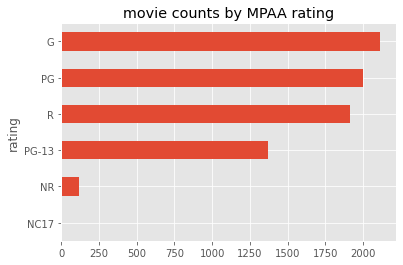

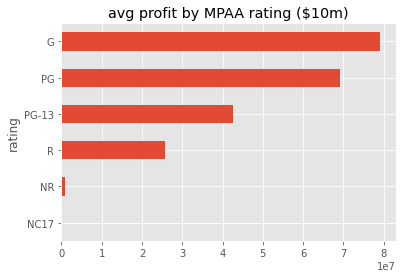

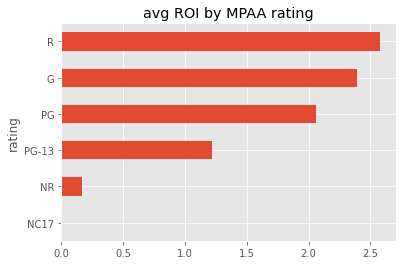

In [46]:
ax1 = pd.DataFrame(ratings_count).plot.barh(x=0, y=1, xlabel='rating',
                                            title='movie counts by MPAA rating', legend=None)
ax2 = pd.DataFrame(ratings_profit).plot.barh(x=0, y=1, xlabel='rating',
                                             title='avg profit by MPAA rating ($10m)', legend=None)
ax3 = pd.DataFrame(ratings_ROI).plot.barh(x=0, y=1, xlabel='rating',
                                          title='avg ROI by MPAA rating', legend=None)

From the above, we see that movies are profitable pretty much according to the size of the population eligible to watch them (by age). That is, G movies are most profitable, presumably because their potential audience includes all moviegoers.

For ROI, however, R movies consistenly fetch greater returns on investment. After R-rated movies, the order of ratings for ROI follows the order of ratings for profits.

### past profit and ROI of director — more feature creation

Here we will create new dataframes with columns for data on how a director's experience does or does not affect the profits and ROI of a movie. This will be explained in more detail further down. First we must create a dataframe  that includes records of movies where the director is known.

In [47]:
# prepare trimmed version of tn_df
df0 = tn_df.drop(['id', 'release_date', 'budget', 'domestic_gross', 'gross', 'multiplier'], axis=1)

# merge with movie_basics to get movie id
dir_df_1 = df0.merge(movie_basics_df[['title', 'year', 'movie_id']])

# merge with directors to get person id
dir_df_1 = dir_df_1.merge(directors_df[['movie_id', 'person_id']])

# merge with persons to get director name
dir_df_1 = dir_df_1.merge(persons_df[['person_id', 'primary_name']])

# standardize column name for director
dir_df_1.rename(columns={'primary_name': 'director'}, inplace=True)

# show how many records we've captured
dir_df_1.count()['title']

1567

In [48]:
# merge with rotten tomatoes
dir_df_2 = df0.merge(rtm_df[['title', 'year', 'director']])

# drop records that lack a director
dir_df_2.dropna(subset=['director'], inplace=True)

# show how many records we've captured
dir_df_2.count()['title']

3990

In [49]:
# combine the dataframes
dir_df = pd.concat([dir_df_1, dir_df_2])

# show how many records we've captured
dir_df.count()['title']

5557

The Numbers had 1,567 records in common with IMDb and 3,990 records in common with Rotten Tomatoes, totalling 5,557 when combined.

Entries will be considered sufficiently unique if they have the same title, year, and director. We can drop any records that duplicate all three of these values.

In [50]:
# drop duplicates for title, year and director; keep first record
dir_df.drop_duplicates(subset=['title', 'year', 'director'], keep='first', inplace=True)

# show how many records we've captured
dir_df.count()['title']

4541

Now we will create and apply a function that will allow us to assess the effect that a certain role player's experience has on the financial success of a movie.

For example:
* Consider the movie Jurassic Park, whose profit (adjusted for inflation) was \$1.75 billion
* This movie was directed by Steven Spielberg in 1993
* Our function will look at all other movies directed by Steven Spielberg *before* 1993 (e.g. Jaws, E.T., The Color Purple, etc., but *not* Saving Private Ryan, Minority Report, etc.)
* Our function will then calculate the average profit (adjusted for inflation) of all those movies
* This value (which happens to be \$883 million) is the "past profit" value for the movie Jurassic Park in this dataframe


* Finally, we will apply this same function to find past ROI

For all first-time directors, or for movies whose directors we have no prior data on, there will be no value for "past profit" or "past ROI". We will treat these as separate cases in separate dataframes.

In [51]:
# this function will help create a new column that describes the following:
# for a given TITLE, YEAR, and DIRECTOR ...
# we will look at all EARLIER records from that director ...
# and return the AVERAGE of the indicated column value (profit or ROI)

def past(df, role, person, year, col):
    df_new = df[(df[role] == person) &
                (df['year'] < year)]
    return df_new[col].mean()

# create new column
dir_df['past profit'] = dir_df.apply(lambda x: past(dir_df, 'director', x.director, x.year, 'profit'), axis=1)

# create new column
dir_df['past ROI'] = dir_df.apply(lambda x: past(dir_df, 'director', x.director, x.year, 'ROI'), axis=1)

# split this dataframe into two, according to ones with past experience records and without
dir_exp_df = dir_df[dir_df['past ROI'].notna()]
dir_none_df = dir_df[dir_df['past ROI'].isna()]

# show how many of the recrods include past data
dir_exp_df.count()['title']

2206

Below, we'll explore some values that compare movies for whose directors we DO or DO NOT have past data. (In the latter case, it could mean this is either the director's first time directing, or it could mean we just don't have any earlier records for movies this director directed.)

In [52]:
# avg profit for movies whose directors we HAVE past data
dir_exp_df['profit'].mean()

130868994.61036833

In [53]:
# avg profit for movies whose directors we do NOT have past data
dir_none_df['profit'].mean()

87419264.03430764

In [54]:
# avg ROI for movies whose directors we HAVE past data
dir_exp_df['ROI'].mean()

3.376656594426779

In [55]:
# avg ROI for movies whose directors we do NOT have past data
dir_none_df['ROI'].mean()

6.269452132864546

It is unclear what to do with this information. Taken at face value, it suggests that first-time directors make less profit but fetch far higher ROI. There are many reasons this could be the case, however. For one, directors are usually trusted with greater budgets as they gain experience.

As we continue, we will focus just on records where we have past data for the director.

Below, we'll look at that data as a scatterplot together with a 45° line. Any points exactly on the 45° line are values that indicate a movie's profit (or ROI) was exactly the same as that of its director's past average. So any points *above* that line represent movies that *exceeded* the records of their directors.

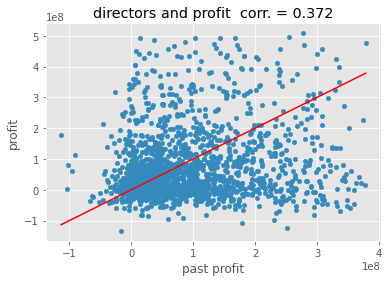

In [56]:
past_plot(dir_exp_df, 'profit', 'directors and profit  corr. = 0.372');

In [57]:
dir_exp_df['profit'].corr(dir_exp_df['past profit'])

0.372294210919767

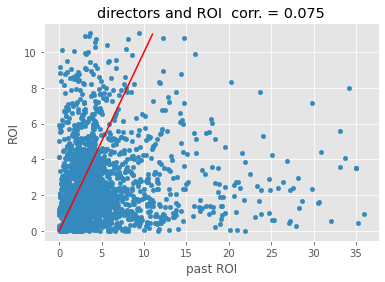

In [58]:
past_plot(dir_exp_df, 'ROI', 'directors and ROI  corr. = 0.075');

In [59]:
dir_exp_df['ROI'].corr(dir_exp_df['past ROI'])

0.07535707075244609

Correlation calculations indicate a moderate correlation between past and current profit for a director. However, there was essentially no correlation between past and current ROI.

### "star power"

Here we will use the same function that we used to calculate "past profit" and "past ROI" for directors, but with a modification to which role players we're looking at.

Instead of the director of a movie, here we will look at what IMDb lists as the top two "principals" of a movie. In most cases, these are the top-billed actors and actresses (the two leads). The only notable exception is when one of the top two principals is the director. In such instances, we have ignored the details of that director and looked only at one principal (actor or actress) of a movie.

In [60]:
# prepare trimmed version of tn_df
df0 = tn_df.drop(['id', 'release_date', 'budget', 'domestic_gross', 'gross', 'multiplier'], axis=1)

# merge with movie_basics to get movie id
star_df = df0.merge(movie_basics_df[['title', 'year', 'movie_id']])

# merge with principals to get person id and orderings
star_df = star_df.merge(principals_df[['movie_id', 'ordering', 'person_id', 'category']])

star_df = star_df[(star_df['ordering'] <= 2) &
                 ((star_df['category'] == 'actress') |
                 (star_df['category'] == 'actor'))]

# merge with persons to get principal name
star_df = star_df.merge(persons_df[['person_id', 'primary_name']])

# standardize column name for director
star_df.rename(columns={'primary_name': 'star'}, inplace=True)

# show how many records we've captured
star_df.count()['title']

2759

In [61]:
# create new column
star_df['past profit'] = star_df.apply(lambda x: past(star_df, 'star', x.star, x.year, 'profit'), axis=1)

# create new column
star_df['past ROI'] = star_df.apply(lambda x: past(star_df, 'star', x.star, x.year, 'ROI'), axis=1)

# split this dataframe into two, according to ones with past experience records and without
star_exp_df = star_df[star_df['past ROI'].notna()]
star_none_df = star_df[star_df['past ROI'].isna()]

# show how many of the recrods include past data
star_exp_df.count()['title']

1280

Now we'll look at the scatterplots and correlation calculations, just as we did with directors.

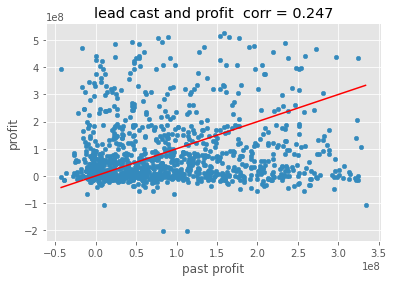

In [62]:
past_plot(star_exp_df, 'profit', 'lead cast and profit  corr = 0.247');

In [63]:
star_exp_df['profit'].corr(star_exp_df['past profit'])

0.2465705883142871

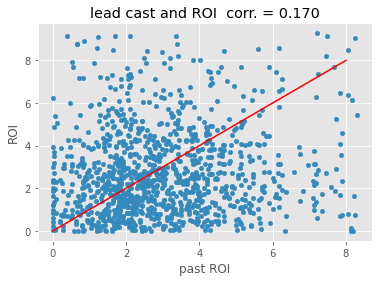

In [64]:
past_plot(star_exp_df, 'ROI', 'lead cast and ROI  corr. = 0.170');

In [65]:
star_exp_df['ROI'].corr(star_exp_df['past ROI'])

0.16951093631432715

# Recommendations

Many of the attributes we examined had different results depending on whether Microsoft wishes to maximize their profits or their ROI. We cover each case.

## Runtime

We can't offer any confident predictions for runtimes outside the typical range of 80-130 minutes. Within that range, it seems clear that longer runtimes correlate to higher average profits and lower average ROI. Any runtime within this range could potentially achieve Microsoft's aims, depending on whether they're looking for large profits or reliable returns.

## Genre

Action movies make the largest average profits, while dramas yield the highest average ROI. Comedy and suspense both fare moderately at both profits and ROI. Sci-fi & fantasy movies yield higher profits with lower ROI, while horror movies accomplish roughly the opposite. All other genres appear to be inferior in both metrics.

## MPAA rating

Depending on Microsoft's aims, they could produce more G-rated movies (to generate higher profits) or more R-rated movies (to generate more reliable ROI). PG movies are moderate in both metrics. PG-13 and NC-17 movies are least successful.

## Director and cast history

The only moderate correlation existed between past and current profit for a director. If Microsoft is interested in maximizing profits, they should attempt to hire directors who have made profitable movies before. If on the other hand they are interested in yielding higher ROI, they should focus much less on the choice of director and, if anything, more carefully consider casting choices, as the lead actors' and actresses' past ROI is more highly correlated to a movie's ROI.

# Recap

**If Microsoft is interested in larger profits,** they should produce some combination of
1. *longer* movies
2. *action* movies
3. rated G
4. directed by directors whose past movies have been profitable

**If Microsoft is concerned with higher average ROI**, they should produce some combination of
1. *shorter* movies
2. *dramas*
3. rated R
4. featuring lead actors and actresses whose past movies have yielded high ROI

# Appendix: Images created for slideshow presentation

In [66]:
df1 = tn_df.merge(movie_basics_df[['title', 'year']])

df2 = tn_df.merge(rtm_df[['title', 'year']])

df3 = pd.concat([df1, df2]).drop_duplicates(subset=['title', 'year'], keep='first')

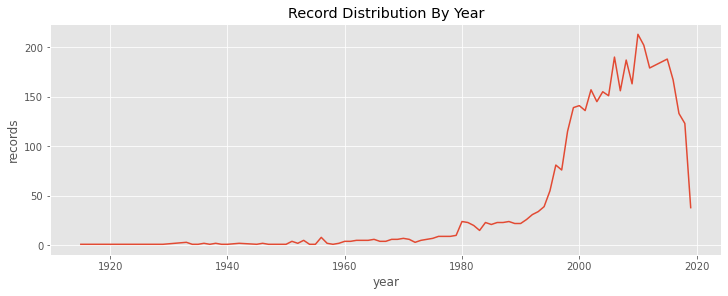

In [67]:
start = 0
end = 2020

fig, ax = plt.subplots(1,1)

fig.set_figwidth(10)

ax.plot(yr_plt(df3, start, end))
ax.set_xlabel('year')
ax.set_ylabel('records')
ax.set_title('Record Distribution By Year')

fig.tight_layout(pad = 0.3)

plt.show()

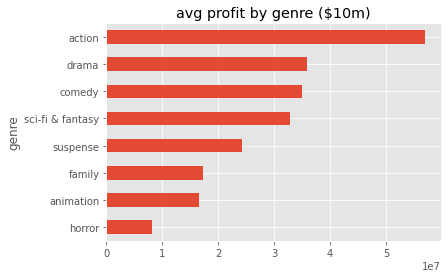

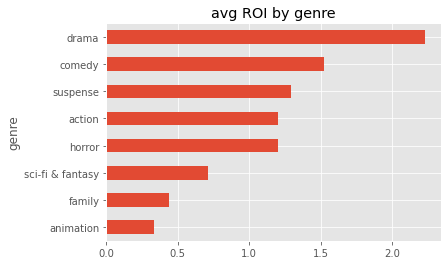

In [68]:
genres = {'action', 'animation', 'comedy', 'drama', 'family', 'horror', 'sci-fi & fantasy', 'suspense'}
genre_count = {}
genre_profit = {}
genre_ROI = {}

for genre in genres:
    genre_count[genre] = genre_df.genres.str.contains(genre).sum()
    genre_profit[genre] = int(round((genre_df.genres.str.contains(genre) * genre_df.profit).mean(),0))
    genre_ROI[genre] = round((genre_df.genres.str.contains(genre) * genre_df.ROI).mean(),2)

genre_count = sorted(genre_count.items(), key=lambda x: x[1])
genre_profit = sorted(genre_profit.items(), key=lambda x: x[1])
genre_ROI = sorted(genre_ROI.items(), key=lambda x: x[1])

ax2 = pd.DataFrame(genre_profit).plot.barh(x=0, y=1, xlabel='genre', title='avg profit by genre ($10m)', legend=None)
ax3 = pd.DataFrame(genre_ROI).plot.barh(x=0, y=1, xlabel='genre', title='avg ROI by genre', legend=None)